In [2]:
%matplotlib inline
import seaborn as sns
import openml as oml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from matplotlib.ticker import FormatStrFormatter
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import random
from scipy.io import savemat
plt.rcParams['figure.dpi']= 120
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8 


import sys

import os

from IPython.core.display import display, HTML

from bayesian.bin import abda
import pprint
import warnings
warnings.filterwarnings('ignore')

D:\Programfiles\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [145]:
data = oml.datasets.get_dataset(984)  # typical datasets 985 4 897
X, y, features = data.get_data(target=data.default_target_attribute, return_attribute_names=True)
Xy = data.get_data()
Xy

array([[305., 133.,   0.,   8.,   1.],
       [159., 195.,   0.,   3.,   1.],
       [251., 336.,   0.,  11.,   1.],
       ...,
       [ 16., 145.,  11.,   4.,   1.],
       [  3., 192.,  11.,   1.,   1.],
       [100., 126.,  11.,   5.,   0.]], dtype=float32)

In [146]:
def identify_missing(df=None):
    """
    Detect missing values
    
    ---
    input:
    
    df : The input DataFrame
    
    """
    
    display(HTML('<h4>Identify Missing Data ...</h4>'))
    na_values=['n/a', 'na', '--', '?']
    print('The default setting of missing characters is {}'.format(na_values))
    ans = input('Do you want to add extra character? [y/n]')
    if ans == 'y':
        char = input('Input the character to be identified as missing: ')
        na_values.append(char)
        print('New missing character added!')
        print(na_values)
    else:
        pass
    for value in na_values:
        df = df.replace(value, np.nan)
    
    # flag indicates whether any missing value is detected
    flag = df.isnull().values.any()
    if flag:
        print("")
        display(HTML('<bold>Missing values detected!</bold>'))
        print("")
        # number of missing in each feature
        print("Number of missing in each feature")
#         for col in df.columns:
#             print(df[col].isnull().sum())
        print(df.isnull().sum())
        print("")
        print("Records containing missing values:")
        display(df[df.isnull().any(axis=1)].head())
        print("")
#         # number of missing in each row
#         for i in df.isnull().sum(axis=1):
#             print(i)
        # identify missing mechanism
        identify_missing_mechanism(df)
        # visualize missing data
#         visualize_missing(df)
    else:
        print("No missing value detected")
    return flag

In [147]:
def identify_missing_mechanism(df=None):
    """
    Try to guess missing mechanism of the dataset
    MCAR: Missing completely at ramdom
    MAR: Missing at random
    MNAR: Missing not at random (not available here, normally involes field expert)
    
    ---
    input:
    
    df: input DataFrame
    
    """
    # Pearson correlation coefficient between every 2 features
#     print("")
#     print("Missing correlation (Pearson correlation coefficient) between every 2 features")
#     display(df.isnull().corr())
    df2 = df.copy()
    missing_columns = df2.columns[df2.isnull().any(axis=0)] # columns containing missing values
    # relace nan as true, otherwise false for features containing missing values
    df2[df2.columns[df2.isnull().any(axis=0)]] = df2[df2.columns[df2.isnull().any(axis=0)]].isnull() 
    df2[missing_columns] = df2[missing_columns].astype(int) # replace true as 1, false as 0
    df_missing_corr = df2.corr()[missing_columns] # compute correlations between features containing missing values and other features
    print("Missing correlation between features containing missing values and other features")
    display(df_missing_corr)
    flag_mar = False
    # test if there is some correlation of a value being missed in feature and the value of any other of the features
    for col in df_missing_corr:
        list_high_corr =[]
        list_high_corr = list_high_corr + (df_missing_corr[col].index[df_missing_corr[col]>0.6].tolist())
        list_high_corr.remove(int(col))
#         print(list_high_corr)
        if list_high_corr:
            flag_mar = True
    if flag_mar:
        display(HTML('<bold>Missing mechanism is probably missing at random</bold>'))
    else:
        display(HTML('<bold>Missing mechanism is probably missing completely at random</bold>'))
#     tri_lower_no_diag = np.tril(df.isnull().corr(), k=-1)
#     # if any 2 features highly missing correlated
#     if (tri_lower_no_diag > 0.6).any() or (tri_lower_no_diag < -0.6).any():
#         display(HTML('<bold>Missing mechanism is highly possible to be missing at random</bold>'))
#     elif (tri_lower_no_diag > -0.2).all() and (tri_lower_no_diag < 0.2).all():
#         display(HTML('<bold>Missing mechanism is highly possible to be missing completely at random</bold>'))
#     else:
#         display(HTML('<bold>Missing mechanism is hard to guess</bold>'))

In [148]:
identify_missing(pd.DataFrame(X))

The default setting of missing characters is ['n/a', 'na', '--', '?']
Do you want to add extra character? [y/n]n




Number of missing in each feature
0    0
1    1
2    0
3    0
dtype: int64

Records containing missing values:


,0,1,2,3
59,285.0,NaN,1.0,5.0



Missing correlation between features containing missing values and other features


,1
0,0.050284
1,1.000000
2,-0.068455
3,-0.007790


True

### Draft below

In [125]:
df2 = pd.DataFrame(X).copy()

In [126]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,28.0,1.0,3.0,130.0,132.0,1.0,0.0,185.0,0.0,0.0,NaN,NaN,NaN
1,29.0,1.0,3.0,120.0,243.0,1.0,1.0,160.0,0.0,0.0,NaN,NaN,NaN
2,29.0,1.0,3.0,140.0,NaN,1.0,1.0,170.0,0.0,0.0,NaN,NaN,NaN
3,30.0,0.0,0.0,170.0,237.0,1.0,2.0,170.0,0.0,0.0,NaN,NaN,0.0
4,31.0,0.0,3.0,100.0,219.0,1.0,2.0,150.0,0.0,0.0,NaN,NaN,NaN


In [127]:
missing_columns = df2.columns[df2.isnull().any(axis=0)] # columns containing missing values

In [128]:
# relace nan as true, otherwise false for features containing missing values
df2[df2.columns[df2.isnull().any(axis=0)]] = df2[df2.columns[df2.isnull().any(axis=0)]].isnull() 

In [129]:
df2[missing_columns] = df2[missing_columns].astype(int) # replace true as 1, false as 0

In [130]:
df_missing_corr = df2.corr()[missing_columns] # compute correlations between features containing missing values and other features

In [131]:
df_missing_corr

,3,4,5,6,7,8,10,11,12
0,0.001300,0.021098,-0.015045,0.053738,0.001300,0.001300,-0.233563,-0.054337,0.001698
1,-0.094736,-0.018804,-0.084038,0.036026,-0.094736,-0.094736,-0.042244,-0.062613,-0.018525
2,0.069328,0.080302,0.023245,-0.114298,0.069328,0.069328,0.344377,0.021348,0.076310
3,1.000000,-0.017019,-0.009771,-0.003413,1.000000,1.000000,-0.078963,0.005932,0.018954
4,-0.017019,1.000000,-0.048724,-0.017019,-0.017019,-0.017019,0.083079,-0.096455,0.051369
5,-0.009771,-0.048724,1.000000,-0.009771,-0.009771,-0.009771,-0.007436,0.016982,-0.088177
6,-0.003413,-0.017019,-0.009771,1.000000,-0.003413,-0.003413,0.043222,0.005932,0.018954
7,1.000000,-0.017019,-0.009771,-0.003413,1.000000,1.000000,-0.078963,0.005932,0.018954
8,1.000000,-0.017019,-0.009771,-0.003413,1.000000,1.000000,-0.078963,0.005932,0.018954
9,0.091063,-0.083492,-0.038914,-0.037744,0.091063,0.091063,-0.841888,0.009632,0.005231


In [132]:
df_missing_corr.index[df_missing_corr[3]>0.6]

Int64Index([3, 7, 8], dtype='int64')

In [133]:
flag_mar = False
# if there is some correlation of a value being missed in feature and the value of any other of the features
for col in df_missing_corr:
    list_high_corr =[]
    list_high_corr = list_high_corr + (df_missing_corr[col].index[df_missing_corr[col]>0.6].tolist())
    list_high_corr.remove(int(col))
    print(list_high_corr)
    if list_high_corr:
        flag_mar = True

[7, 8]
[]
[]
[]
[3, 8]
[3, 7]
[]
[]
[]


In [134]:
flag_mar

True

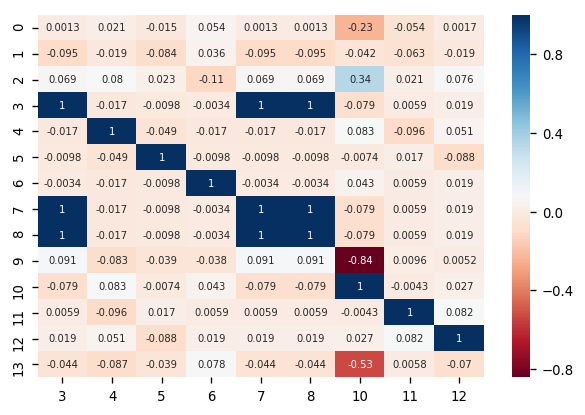

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.heatmap(df_missing_corr, annot=True,  annot_kws={'size': 6}, cmap="RdBu")
plt.show()

# sns.heatmap(corr_mat, mask=mask, cmap=cmap, ax=ax0, cbar=False,
#                     annot=True, annot_kws={'size': fontsize - 2})